In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import seaborn as sns
import math

folder = '../Data/test/images'

for filename in os.listdir(folder):
    print(filename)

for filename in os.listdir(folder):
    img = cv.imread(os.path.join(folder,filename))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret,thresh = cv.threshold(img,100,255,cv.THRESH_BINARY_INV)
    img_name = filename.replace("rgb", "msk")
    cv.imwrite(f"../Data/test/masks/{img_name}", thresh)

In [2]:
#img = cv.imread('wire.jpg')
img = cv.imread('../Data/sample images/2.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, (400, 400))

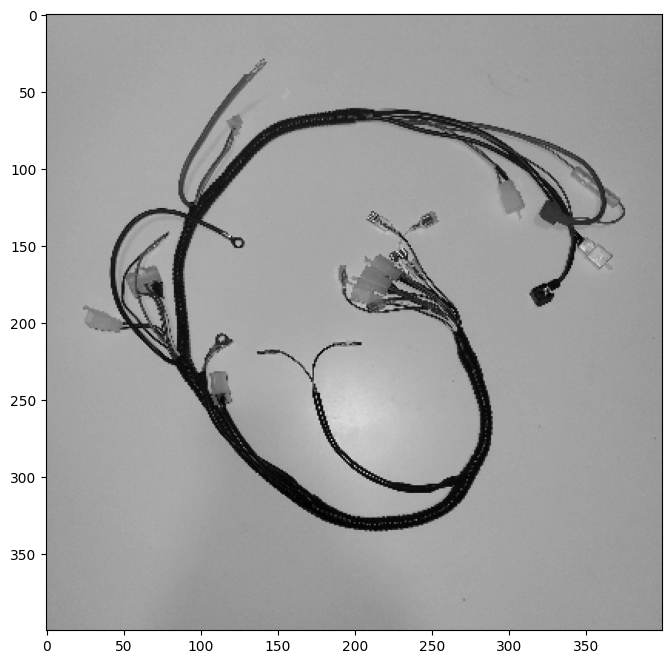

In [3]:
plt.subplots(figsize=(10,8)),plt.imshow(img, 'gray', vmin=0, vmax=255)
plt.show()

In [4]:
_,thresh2 = cv.threshold(img,100,255,cv.THRESH_BINARY_INV)

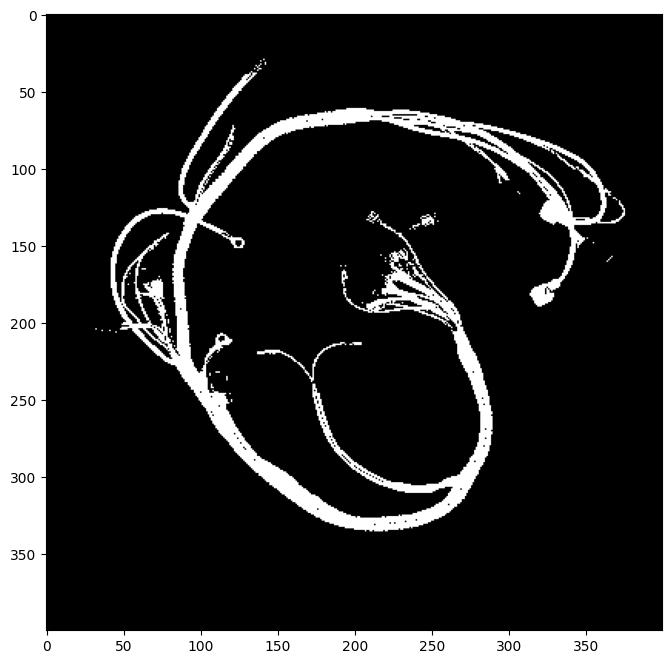

In [5]:
plt.subplots(figsize=(10,8)),plt.imshow(thresh2, 'gray')
plt.show()

contours, _= cv.findContours(thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

len(contours)

contours_clean = []
for c in contours:
    area = cv.contourArea(c)
    if area > 5.0:
        contours_clean.append(c)

len(contours_clean)

cont_index = np.array(areas).argmax()
wire_cont = contours[cont_index]

#new_mask = cv.drawContours(thresh2, [wire_cont], -1, color=(255, 255, 255), thickness=cv.FILLED)
new_mask = cv.drawContours(thresh2, contours_clean, -1, color=(255, 255, 255), thickness=cv.FILLED)

plt.subplots(figsize=(10,8)),plt.imshow(new_mask, 'gray')
plt.show()

In [6]:
points = np.transpose(np.nonzero(thresh2))

In [7]:
points

array([[ 29, 141],
       [ 30, 139],
       [ 31, 142],
       ...,
       [335, 218],
       [335, 220],
       [335, 221]], dtype=int64)

In [8]:
knn_graph = kneighbors_graph(points, 30, include_self=False)

In [9]:
clustering = AgglomerativeClustering(n_clusters=30, linkage="ward", connectivity=knn_graph)

In [10]:
clustering.fit(points)

AgglomerativeClustering(connectivity=<11542x11542 sparse matrix of type '<class 'numpy.float64'>'
	with 346260 stored elements in Compressed Sparse Row format>,
                        n_clusters=30)

In [11]:
clustering.labels_

array([18, 18, 18, ..., 24, 24, 24], dtype=int64)

In [12]:
df = pd.DataFrame(points)
df['cluster'] = clustering.labels_
df.columns = ['Y', 'X', 'clusters']
df['Y'] = df['Y'] * (-1)

In [13]:
df

,Y,X,clusters
0,-29,141,18
1,-30,139,18
2,-31,142,18
3,-32,139,18
4,-32,142,18
...,...,...,...
11537,-335,216,24
11538,-335,217,24
11539,-335,218,24
11540,-335,220,24


In [14]:
df['clusters'].unique()

array([18,  2,  0, 13,  8,  5, 23, 14,  3,  4, 10, 22, 20, 12, 29,  7, 21,
       27, 25,  9, 26, 11, 28,  6, 15, 19, 16,  1, 17, 24], dtype=int64)

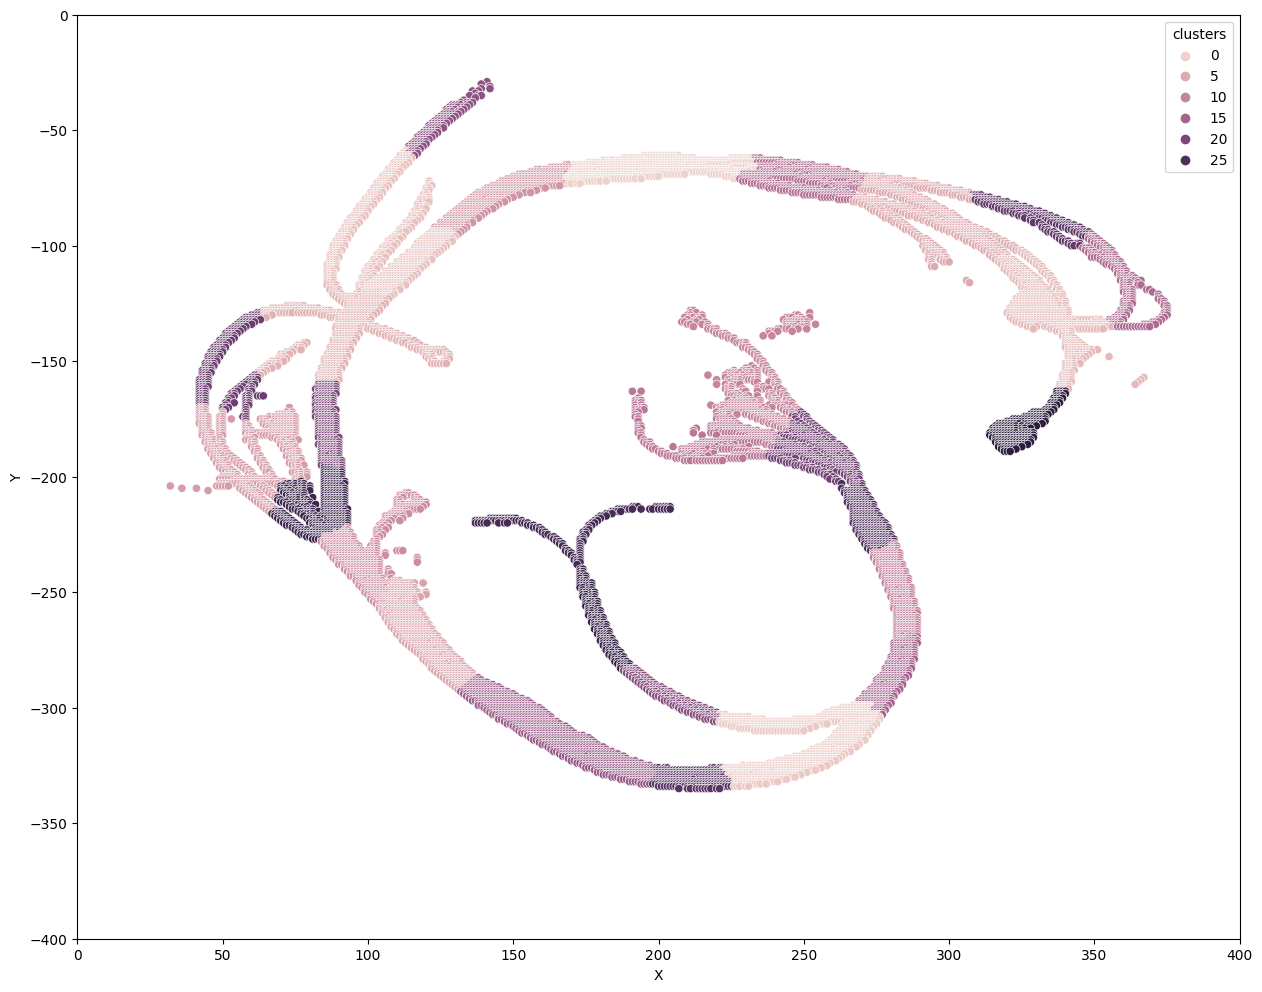

In [15]:
fig,ax = plt.subplots(figsize=(15,12))
sns.scatterplot(data=df, x="X", y='Y', hue="clusters", ax=ax)
_=ax.set_xlim(0,400)
_=ax.set_ylim(-400,0)

In [16]:
df_points = df.groupby('clusters').agg({'X':[np.mean], 'Y':[np.mean]}).reset_index()

In [17]:
df_points.columns = ['cluster', 'X_cent', 'Y_cent']
df_points = df_points.apply(round)
df_points['Y_cent'] = df_points['Y_cent'] + 400.0
df_points

,cluster,X_cent,Y_cent
0,0,199.0,334.0
1,1,250.0,85.0
2,2,108.0,302.0
3,3,334.0,270.0
4,4,93.0,263.0
5,5,293.0,313.0
6,6,119.0,132.0
7,7,61.0,210.0
8,8,146.0,322.0
9,9,100.0,167.0


In [18]:
points_list = list(df_points[['X_cent', 'Y_cent']].itertuples(index=False, name=None))

In [19]:
limit_points = []

In [20]:
for point1 in points_list:
    distances = []
    points = []
    
    for point2 in points_list:
        if point1 != point2:
            distance = math.dist(point1, point2)
            distances.append(distance)
            points.append(point2)

    min_dist_1 = min(distances)
    min_idx_1 = distances.index(min_dist_1)
    
    distances.remove(min_dist_1)
    
    min_dist_2 = min(distances)
    min_idx_2 = distances.index(min_dist_2)
    
    distances.remove(min_dist_2)
    
    min_dist_3 = min(distances)
    min_idx_3 = distances.index(min_dist_3)
    
    pt1 = points[min_idx_1]
    pt2 = points[min_idx_2]
    pt3 = points[min_idx_3]
    
    dist1 = min_dist_1
    dist2 = math.dist(pt1, pt2)
    dist3 = math.dist(pt2, pt3)
    
    factor1 = dist2 / dist1
    factor2 = dist3 / dist2
    
    if (factor1 <= 1.3) and (factor1 >= 0.7) and (factor2 <= 1.3) and (factor2 >= 0.7): 
        limit_points.append(point1)

In [21]:
limit_points

[]

In [22]:
list_sorted = [points_list[0]]
points_list.remove(points_list[0])

In [23]:
node_points = []

In [24]:
flag = True

while flag:
    point1 = list_sorted[-1]
    distances = []
    points = []
    
    for point2 in points_list:
        distance = math.dist(point1, point2)
        distances.append(distance)
        points.append(point2)
        
    min_dist_1 = min(distances)
    min_idx_1 = distances.index(min_dist_1)
    
    distances.remove(min_dist_1)
    
    try:
        min_dist_2 = min(distances)
        min_idx_2 = distances.index(min_dist_2)

        factor = min_dist_2 / min_dist_1

        if (factor > 1) and (factor <= 1.3) and (list_sorted[-2] not in node_points) and (list_sorted[-3] not in node_points):
            node_points.append(point1)
            
    except:
        pass
    
    list_sorted.append(points[min_idx_1])
    points_list.remove(points[min_idx_1])
    
    if not points_list:
        flag = False

In [25]:
list_sorted

[(199.0, 334.0),
 (251.0, 329.0),
 (293.0, 313.0),
 (329.0, 313.0),
 (359.0, 283.0),
 (334.0, 270.0),
 (325.0, 222.0),
 (272.0, 181.0),
 (283.0, 150.0),
 (280.0, 114.0),
 (250.0, 85.0),
 (211.0, 69.0),
 (178.0, 79.0),
 (149.0, 100.0),
 (119.0, 132.0),
 (100.0, 167.0),
 (83.0, 187.0),
 (61.0, 210.0),
 (86.0, 222.0),
 (93.0, 263.0),
 (108.0, 302.0),
 (146.0, 322.0),
 (125.0, 353.0),
 (52.0, 248.0),
 (168.0, 178.0),
 (180.0, 137.0),
 (205.0, 105.0),
 (220.0, 216.0),
 (233.0, 242.0),
 (254.0, 211.0)]

In [26]:
df_points = pd.DataFrame(list_sorted, columns=['X', 'Y'])

In [27]:
df_nodes = pd.DataFrame(node_points, columns=['X', 'Y'])

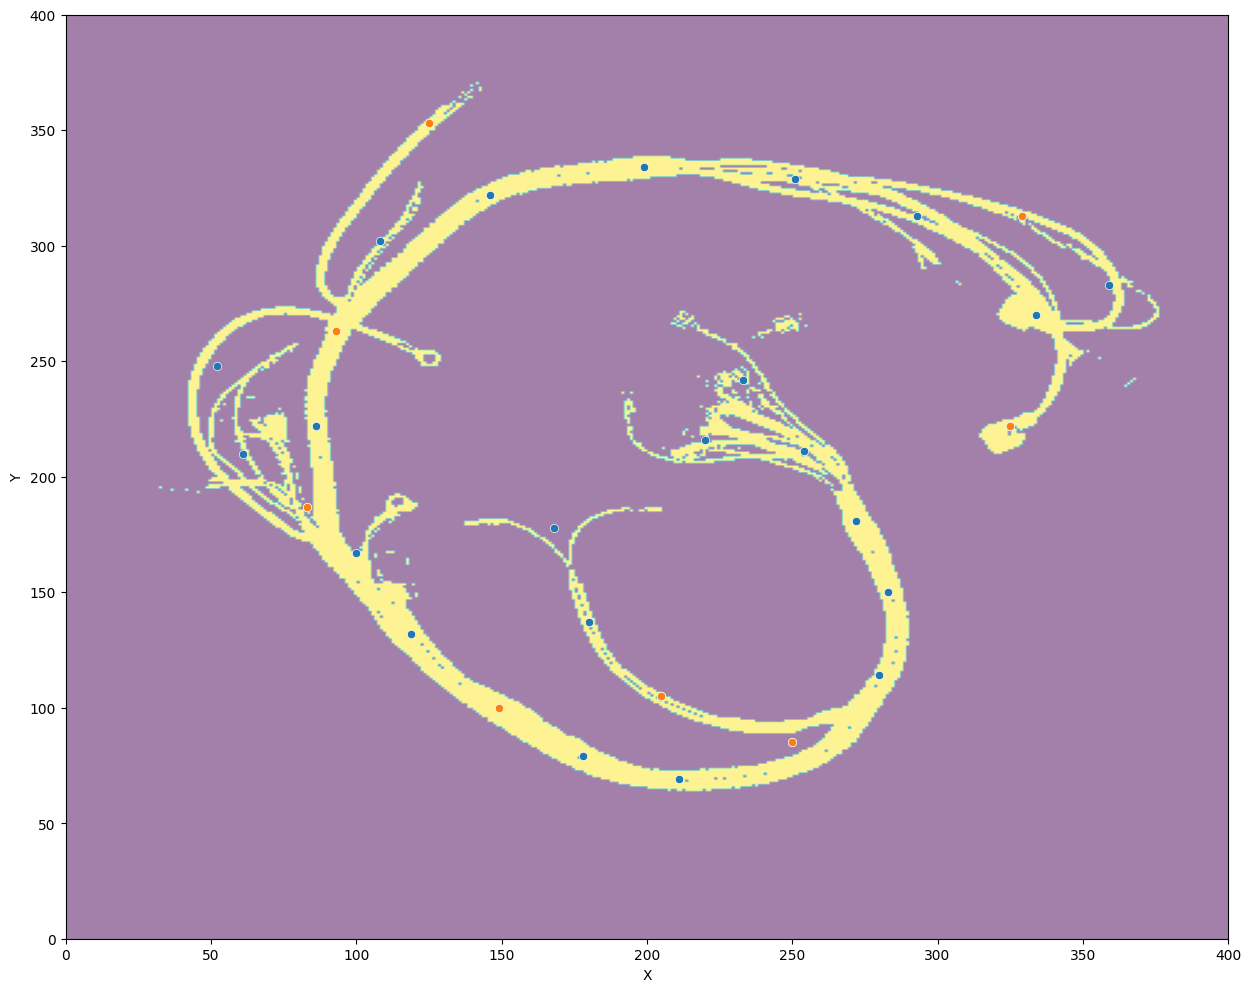

In [28]:
fig,ax = plt.subplots(figsize=(15,12))
sns.scatterplot(data=df_points, x="X", y='Y', ax=ax)
sns.scatterplot(data=df_nodes, x="X", y='Y', ax=ax, palette='flare')
plt.xlim(0, 400)
plt.ylim(0, 400)
#plt.axis('off')
ax.imshow(thresh2, extent=[0, 400, 0, 400], aspect='auto', alpha=0.5)
#plt.savefig('../Data/sample results/1.jpg')

In [29]:
df_points['X'] = df_points['X'] / 8
df_points['Y'] = df_points['Y'] / (8*-1)